In [1]:
import pandas as pd
df = pd.read_csv('/Users/varunjoshi/Documents/Python/STIA_458/stiaFinalProject/test_set.csv')
df.head()

,Iteration,Region,No-Region,Description
0,5.0,Africa,NaN,exam caus consequ forc migrat focus particular...
1,NaN,Africa,NaN,it underli aim familiar recent trend histor sc...
2,NaN,Africa,NaN,take look polit len fiction film our discuss...
3,NaN,Africa,NaN,what how written how written these fundamen...
4,NaN,Africa,NaN,there recent resurg inter-st cooper secur eco...


In [2]:
from io import StringIO
col = ['Region', 'Description']
df = df[col]
df = df[pd.notnull(df['Description'])]
df.columns = ['Region', 'Description']
df['category_id'] = df['Region'].factorize()[0]
category_id_df = df[['Region', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Region']].values)
df.head()

,Region,Description,category_id
0,Africa,exam caus consequ forc migrat focus particular...,0
1,Africa,it underli aim familiar recent trend histor sc...,0
2,Africa,take look polit len fiction film our discuss...,0
3,Africa,what how written how written these fundamen...,0
4,Africa,there recent resurg inter-st cooper secur eco...,0


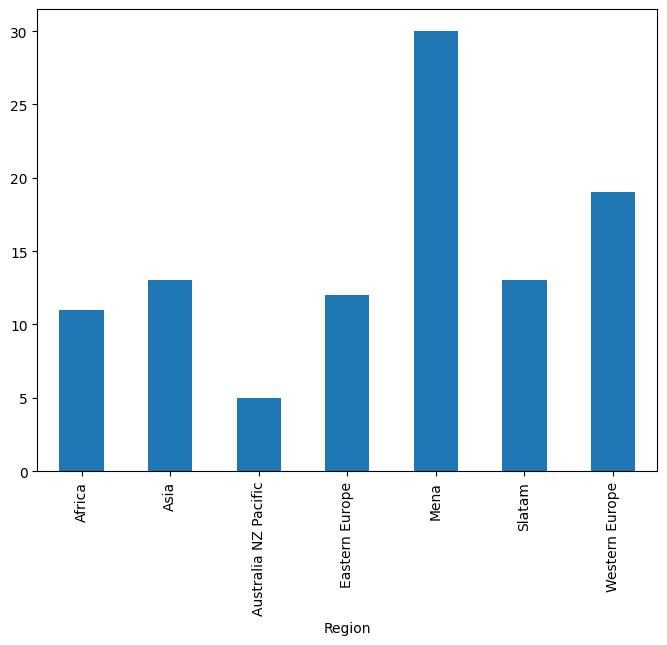

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Region').Description.count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Description).toarray()
labels = df.category_id
features.shape

(103, 402)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 5
for Region, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Region))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Africa':
  . Most correlated unigrams:
. environment
. violenc
. coloni
. trade
. moment
  . Most correlated bigrams:
. 20th centuri
. climat chang
. world war
. unit state
. case studi
# 'Asia':
  . Most correlated unigrams:
. speaker
. home
. skill
. interact
. life
  . Most correlated bigrams:
. econom develop
. intern polit
. 20th centuri
. unit state
. polit economi
# 'Australia NZ Pacific':
  . Most correlated unigrams:
. close
. aftermath
. deep
. affair
. strateg
  . Most correlated bigrams:
. caus consequ
. region intern
. world war
. climat chang
. role world
# 'Eastern Europe':
  . Most correlated unigrams:
. subject
. know
. oper
. labor
. mass
  . Most correlated bigrams:
. case studi
. human right
. world war
. polit econom
. climat chang
# 'Mena':
  . Most correlated unigrams:
. futur
. process
. conflict
. diplomat
. muslim
  . Most correlated bigrams:
. econom develop
. role world
. unit state
. world war
. intern polit
# 'Slatam':
  . Most correlated unigrams:
. co

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Region'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

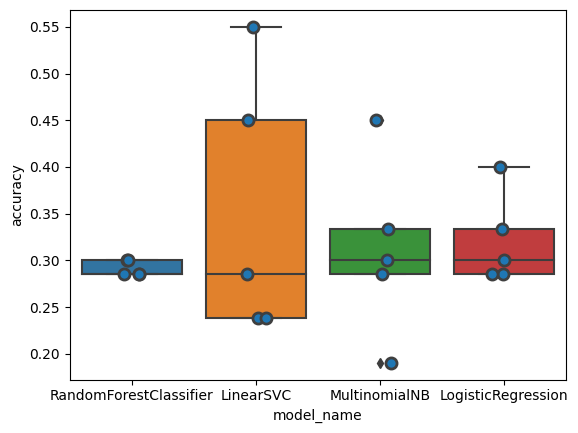

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [8]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.352381
LogisticRegression        0.320952
MultinomialNB             0.311905
RandomForestClassifier    0.291429
Name: accuracy, dtype: float64

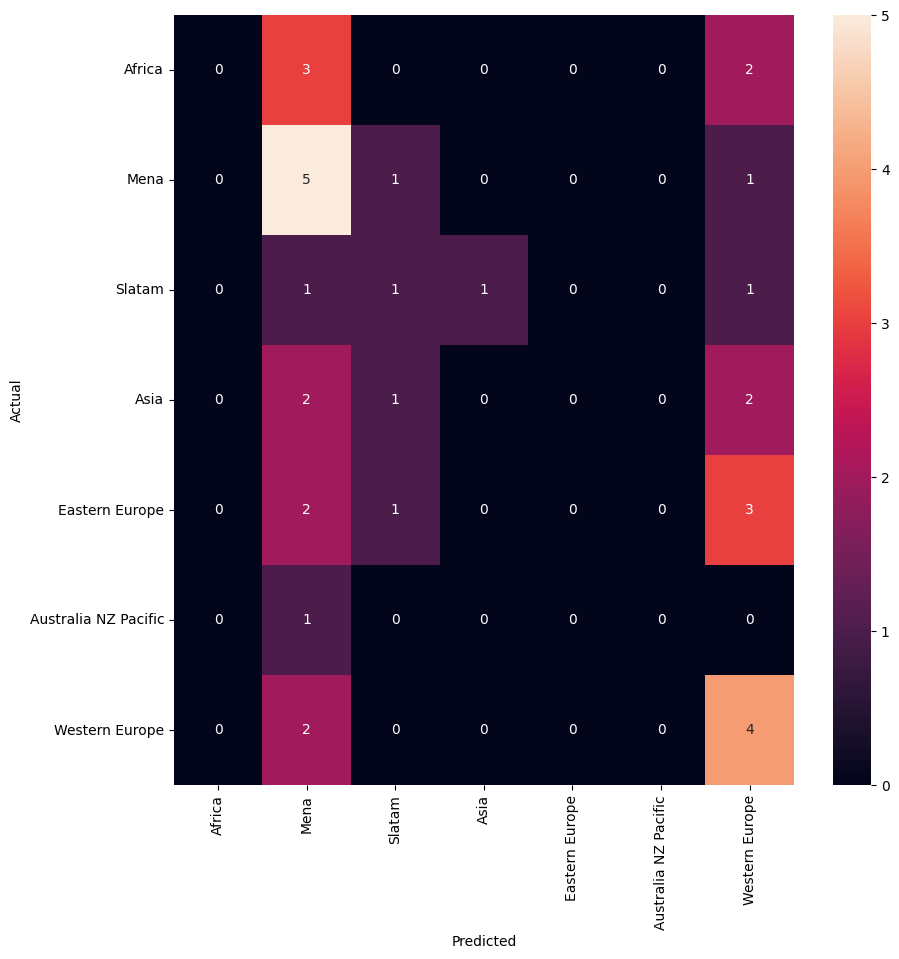

In [9]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Region.values, yticklabels=category_id_df.Region.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
model.fit(features, labels)
N = 5
for Region, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Region))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Africa':
  . Top unigrams:
       . trade
       . coloni
       . impact
       . moment
       . sector
  . Top bigrams:
       . case studi
       . econom develop
       . polit econom
       . particular displac
       . intern regim
# 'Asia':
  . Top unigrams:
       . unit
       . interact
       . life
       . order
       . home
  . Top bigrams:
       . unit state
       . polit economi
       . world war
       . role world
       . polit econom
# 'Australia NZ Pacific':
  . Top unigrams:
       . strateg
       . affair
       . relationship
       . deep
       . close
  . Top bigrams:
       . world war
       . role world
       . climat chang
       . caus consequ
       . region intern
# 'Eastern Europe':
  . Top unigrams:
       . global
       . subject
       . seminar
       . labor
       . view
  . Top bigrams:
       . climat chang
       . polit econom
       . central europ
       . case studi
       . intern polit
# 'Mena':
  . Top unigrams:
       . con

In [11]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Region'].unique()))

                      precision    recall  f1-score   support

              Africa       0.00      0.00      0.00         5
                Mena       0.31      0.71      0.43         7
              Slatam       0.25      0.25      0.25         4
                Asia       0.00      0.00      0.00         5
      Eastern Europe       0.00      0.00      0.00         6
Australia NZ Pacific       0.00      0.00      0.00         1
      Western Europe       0.31      0.67      0.42         6

            accuracy                           0.29        34
           macro avg       0.12      0.23      0.16        34
        weighted avg       0.15      0.29      0.19        34



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.